# Data selection

Patients with diabetes have been selected using following criteria:

* Patient has more than 10 complete records of medication from ATC group **A10B** (Blood glucose lowering drugs, excluding insulins) (both ``rxnorm_id`` and ``generic_rxnorm_id`` were used to select)
* Full record of medication includes ``drug_strength``, ``route`` and ``drug_freq``
* Patient has a least 10 ICD-9 recorded before the first occurrence of an **A10B** medication (``distinct`` by day)
* Patient has a least 24 months of recorded history before the first occurrence of an **A10B** medication
* Patient has no complete record of any medication from ATC group **A10** (Drugs used in diabetes) before first complete record of A10B medication

Control group has been selected using following criteria:

* Patient has no mention of any medication from ATC group **A10** (Drugs used in diabetes) (both ``rxnorm_id`` and ``generic_rxnorm_id`` were used)
* Patient has a least 10 ICD-9 recorded ('distinct' by day)
* Patient has a least 24 months of recorded history

SQL queries and details can be found in ``diabetes/data_generation/1_sql_queries.sql``.

Diabetes group consisted of 10,477 patients, while the control group consisted of 528,068 patients. Due to an imbalance in the number of patients in each group, only portion of controls was selected. Controls were matched to diabetes patients to have similar range and number of codes (see ``diabetes/data_generation/3_control_matching.ipynb`` for details). As a result, both groups consist of 10,477 patients (20,954 total).

The final list of patients was divided into training, test and validation sets (75%/20%/5% respectively). The split was stratified (equal number of positive and negative outcomes in each group). See ``diabetes/data_generation/4_train_test_validation_split.ipynb for details``.

Records, including ICD-9 codes, lab orders and medications for all patients were downloaded. For diabetes patients, only data from before the first occurrence of diabetes medication is used.

# Data processing

Both counts based and vector based datasets have variations with data from:

* 1 day before the cutoff date and older
* 1 month before the cutoff date and older
* 3 months before the cutoff date and older
* 6 months before the cutoff date and older
* 12 months before the cutoff date and older

## Counts

Firstly, medications were mapped to their corresponding ATC class (``diabetes/dataset_generation_counts/1_process_rxcui_atc_map``). Drugs without a mapping were dropped.  ICD-9 codes were mapped to corresponding PHEWAS codes. Counts were then calculated for PHEWAS codes, ATC classes, and lab tests. Vectors were created using ``DictVectorizer`` from scikit-learn package. As a result, datasets have from 4434 (12 months before) to 4535 (1 day before) features.

## Vectors (patient2vec based)

Vector versions of datasets were created using all trained patient2vec models. Vector lengths range from 10 to 1000.

# Classifiers

[XGBoost](https://xgboost.readthedocs.io/en/latest/) was used for classification. No parameter optimization was performed. See ``diabetes/classification_counts`` and ``diabetes/classification_vectors`` for details.


In [1]:
import dill
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from IPython.display import display, HTML

# Initial results (before optimization)

In [2]:
counts_results = pd.read_csv('log/diabetes_counts_simple_xgb.log', header=None)
counts_results.columns = ['Months', 'AUC', 'Logloss']
display(HTML("<h3>Counts results</h3>"))
display(counts_results)

vectors_results = pd.read_csv('log/diabetes_vectors_simple_xgb.log', header=None)
vectors_results.columns = ['Model', 'Months', 'AUC', 'Logloss']
display(HTML("<h3>Vector results (head())</h3>"))
display(vectors_results.head())

,Months,AUC,Logloss
0,0,0.941926,0.306110
1,1,0.925409,0.346202
2,3,0.922815,0.353858
3,6,0.922643,0.356467
4,12,0.919814,0.362080


,Model,Months,AUC,Logloss
0,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,0,0.914158,0.387134
1,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,1,0.900723,0.414907
2,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,3,0.900478,0.411301
3,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,6,0.894006,0.427029
4,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,12,0.896285,0.425964


## Get top patient2vec models

In [3]:
def get_model_info(m_string):
    parts = m_string.split(".")[0].split("_")
    algo = parts[2]
    softmax = parts[3]
    window_size = parts[4].split("-")[1]
    emb_size = parts[5].split("-")[1]
    return "{}, {}, window: {}, embedding: {}".format(algo.upper(), softmax.upper(), window_size, emb_size)

display(HTML("<h3>Top 5 models by top score overall</h3>"))
display(vectors_results.sort_values('AUC', ascending=False)[0:5])
top_models_by_score = vectors_results.sort_values('AUC', ascending=False)[0:5]['Model'].values

display(HTML("<h3>Top 10 models by average score (avreage for all months)</h3>"))
vectors_results_model_groups = vectors_results.groupby(by='Model')
vactors_average_auc = pd.DataFrame.from_records([(model, vals['AUC'].mean()) for model, vals in vectors_results_model_groups], columns=['Model','AUC mean'])
display(vactors_average_auc.sort_values('AUC mean', ascending=False)[0:10])
top_models_by_mean = vactors_average_auc.sort_values('AUC mean', ascending=False)[0:10]['Model'].values

display(HTML("<h3>Combined list of top models</h3>"))
top_models = list(set(top_models_by_mean.tolist() + top_models_by_score.tolist()))
top_models_list_strs = ["<li>{}</li>".format(get_model_info(model)) for model in top_models]
display(HTML("<ul>{}</ul>".format("".join(top_models_list_strs))))

,Model,Months,AUC,Logloss
15,vectors_patient2vec_pvdbow_hs_win-20_emb-100.dill,0,0.917524,0.378635
45,vectors_patient2vec_pvdbow_hs_win-50_emb-100.dill,0,0.917261,0.376252
60,vectors_patient2vec_pvdbow_hs_win-5_emb-100.dill,0,0.915543,0.381078
65,vectors_patient2vec_pvdbow_hs_win-5_emb-300.dill,0,0.915013,0.386192
290,vectors_patient2vec_pvdbow_ns_win-10_emb-50.dill,0,0.914618,0.380735


,Model,AUC mean
7,vectors_patient2vec_pvdbow_hs_win-20_emb-100.dill,0.903694
3,vectors_patient2vec_pvdbow_hs_win-10_emb-300.dill,0.902732
34,vectors_patient2vec_pvdbow_ns_win-10_emb-50.dill,0.902392
19,vectors_patient2vec_pvdbow_hs_win-50_emb-100.dill,0.902117
40,vectors_patient2vec_pvdbow_ns_win-20_emb-50.dill,0.901701
1,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,0.901130
21,vectors_patient2vec_pvdbow_hs_win-50_emb-300.dill,0.899991
13,vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill,0.899889
15,vectors_patient2vec_pvdbow_hs_win-30_emb-300.dill,0.899881
25,vectors_patient2vec_pvdbow_hs_win-5_emb-100.dill,0.899490


# Performance (not optimized)

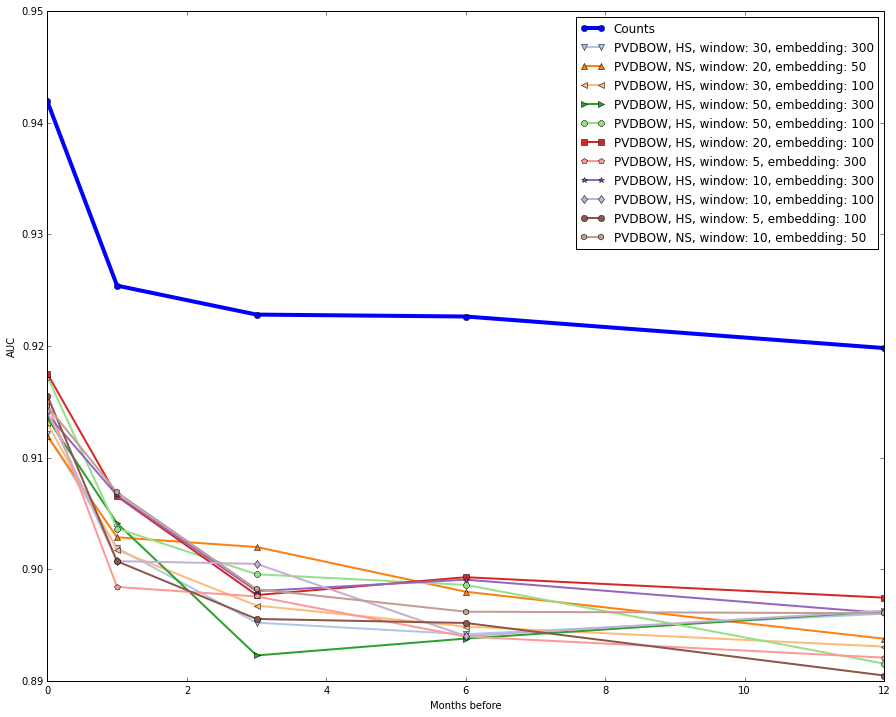

In [4]:
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
markers = "v^<>8sp*doh"

plt.plot(counts_results['Months'], counts_results['AUC'], linewidth=4.0, marker="o", label='Counts')
plt.gca().set_color_cycle(['#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728','#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2','#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5'])
for i, model in enumerate(top_models):
    df = vectors_results_model_groups.get_group(model)
    plt.plot(df['Months'], df['AUC'], linewidth=2.0, marker=markers[i], label=get_model_info(model))
plt.legend(loc='upper right')
plt.xlabel('Months before')
plt.ylabel('AUC')
plt.show()

# Results (optimized) - Elastic Net

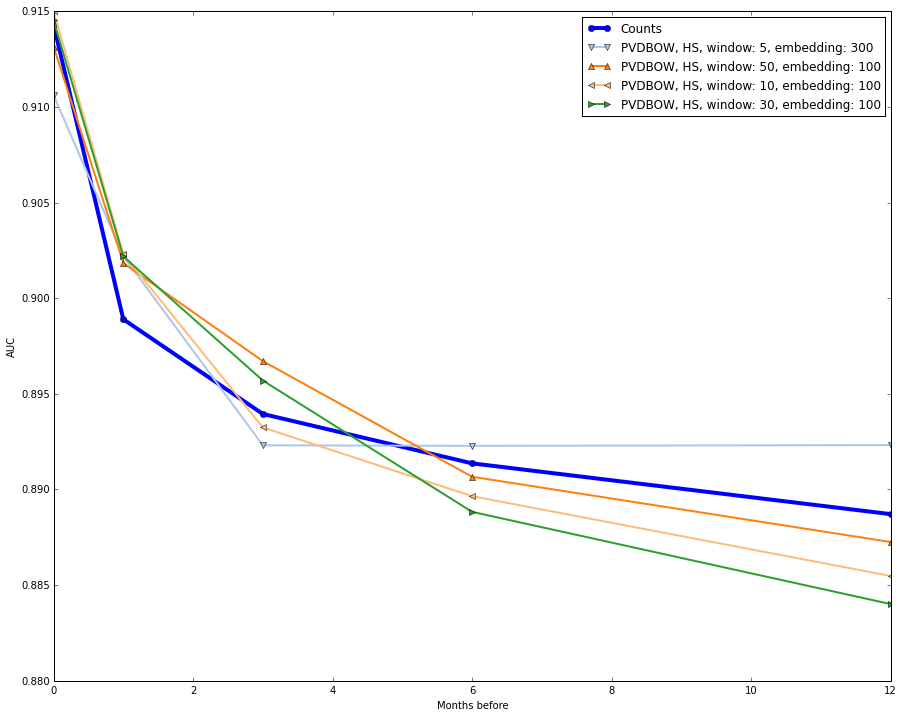

In [5]:
counts_elastic_results = pd.read_csv('log/diabetes_counts_optimized_elasticnet.log', header=None)
counts_elastic_results.columns = ['Months', 'AUC', 'Logloss']


vectors_elastic_results = pd.read_csv('log/diabetes_vectors_optimized_elasticnet.log', header=None)
vectors_elastic_results.columns = ['Model', 'Months', 'AUC', 'Logloss']

# display(HTML("<h3>Top 4 vector-based models by average score (avreage for all months)</h3>"))
vectors_elastic_results_model_groups = vectors_elastic_results.groupby(by='Model')
vactors_elastic_average_auc = pd.DataFrame.from_records([(model, vals['AUC'].mean()) for model, vals in vectors_elastic_results_model_groups], columns=['Model','AUC mean'])
# display(vactors_elastic_average_auc.sort_values('AUC mean', ascending=False)[0:4])
top_elastic_models_by_mean = vactors_elastic_average_auc.sort_values('AUC mean', ascending=False)[0:4]['Model'].values


matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
markers = "v^<>8sp*dohv^<>8sp*dohv^"

plt.plot(counts_elastic_results['Months'], counts_elastic_results['AUC'], linewidth=4.0, marker="o", label='Counts')

plt.gca().set_color_cycle(['#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728','#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2','#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5'])

for i, model in enumerate(top_elastic_models_by_mean):
    df = vectors_elastic_results_model_groups.get_group(model)
    plt.plot(df['Months'], df['AUC'], linewidth=2.0, marker=markers[i], label=get_model_info(model))
plt.legend(loc='upper right')
plt.xlabel('Months before')
plt.ylabel('AUC')
plt.show()


# Results (optimized) - XGBoost

,Model,AUC mean
2,vectors_patient2vec_pvdbow_hs_win-50_emb-100.dill,0.912192
0,vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill,0.911583
3,vectors_patient2vec_pvdbow_hs_win-5_emb-100.dill,0.910415
1,vectors_patient2vec_pvdbow_hs_win-30_emb-50.dill,0.906550


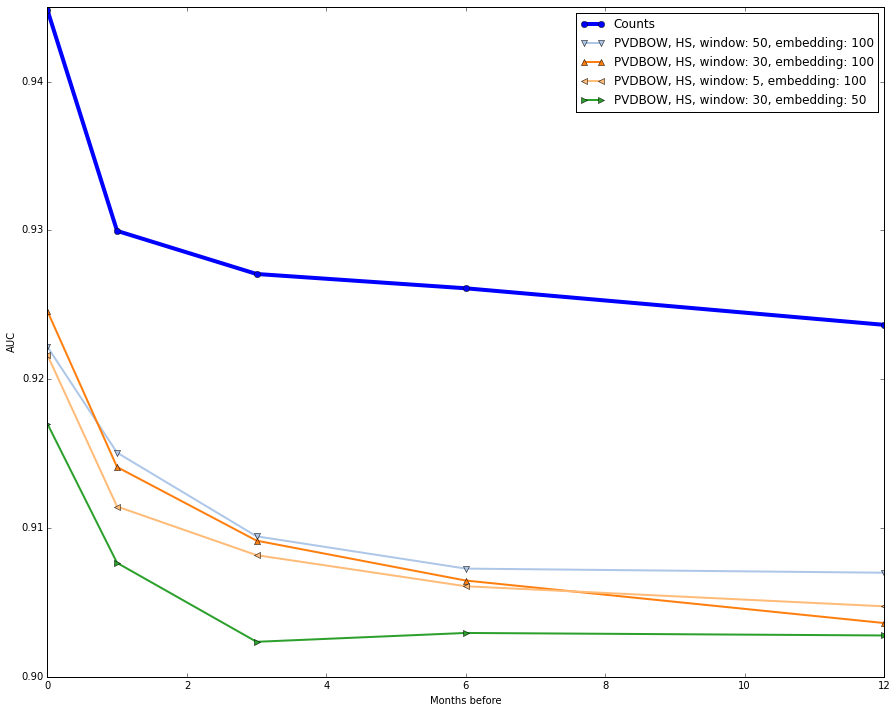

In [6]:
counts_monthly_optim_results = pd.read_csv('log/diabetes_counts_monthly_optimized_xgb.log', header=None)
counts_monthly_optim_results.columns = ['Months', 'AUC', 'Logloss']


vectors_monthly_optim_results = pd.read_csv('log/diabetes_vectors_monthly_optimized_xgb.log', header=None)
vectors_monthly_optim_results.columns = ['Model', 'Months', 'AUC', 'Logloss']

display(HTML("<h3>Top 5 vector-based models by average score (avreage for all months)</h3>"))
vectors_monthly_optim_results_model_groups = vectors_monthly_optim_results.groupby(by='Model')
vactors_monthly_optim_average_auc = pd.DataFrame.from_records([(model, vals['AUC'].mean()) for model, vals in vectors_monthly_optim_results_model_groups], columns=['Model','AUC mean'])
display(vactors_monthly_optim_average_auc.sort_values('AUC mean', ascending=False)[0:5])
top_monthly_optim_models_by_mean = vactors_monthly_optim_average_auc.sort_values('AUC mean', ascending=False)[0:5]['Model'].values


matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
markers = "v^<>8sp*dohv^<>8sp*dohv^"

plt.plot(counts_monthly_optim_results['Months'], counts_monthly_optim_results['AUC'], linewidth=4.0, marker="o", label='Counts')

plt.gca().set_color_cycle(['#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728','#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2','#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5'])

# for i, model in enumerate( np.unique(vectors_monthly_optim_results['Model'].values) ):
for i, model in enumerate(top_monthly_optim_models_by_mean):
    df = vectors_monthly_optim_results_model_groups.get_group(model)
    plt.plot(df['Months'], df['AUC'], linewidth=2.0, marker=markers[i], label=get_model_info(model))
plt.legend(loc='upper right')
plt.xlabel('Months before')
plt.ylabel('AUC')
plt.show()


# ROC curves

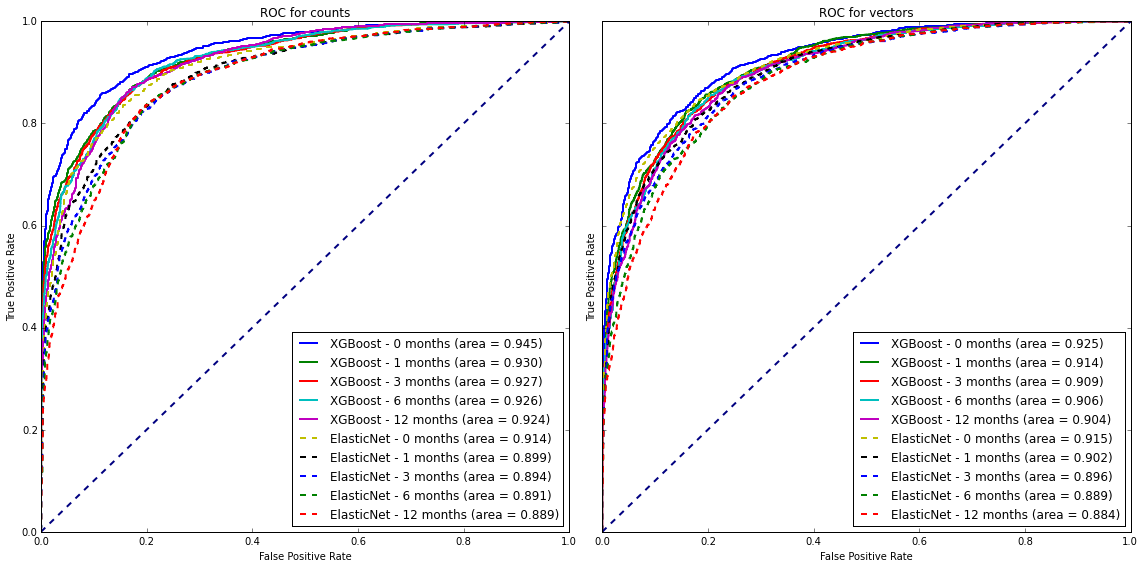

In [7]:
counts_preds = dill.load(open('log/diabetes_counts_monthly_optimized_results.dill', 'rb'))
counts_elasticnet_preds = dill.load(open('log/diabetes_counts_elasticnet_results.dill', 'rb'))

vector_preds = dill.load(open('log/diabetes_vectors_monthly_optimized_results.dill', 'rb'))['vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill']
vector_elasticnet_preds = dill.load(open('log/diabetes_vectors_elasticnet_results.dill', 'rb'))['vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill']


fpr = {'counts': {'xgb': {}, 'elastic': {}}, 'vectors': {'xgb': {}, 'elastic': {}}}
tpr = {'counts': {'xgb': {}, 'elastic': {}}, 'vectors': {'xgb': {}, 'elastic': {}}}
roc_auc = {'counts': {'xgb': {}, 'elastic': {}}, 'vectors': {'xgb': {}, 'elastic': {}}}

for months in sorted(list(counts_preds.keys())):
    fpr['counts']['xgb'][months], tpr['counts']['xgb'][months], _ = roc_curve(counts_preds[months]['true_y'], counts_preds[months]['pred_y'][:, 1])
    roc_auc['counts']['xgb'][months] = auc(fpr['counts']['xgb'][months], tpr['counts']['xgb'][months])
for months in sorted(list(counts_elasticnet_preds.keys())):
    fpr['counts']['elastic'][months], tpr['counts']['elastic'][months], _ = roc_curve(counts_elasticnet_preds[months]['true_y'], counts_elasticnet_preds[months]['pred_y'][:, 1])
    roc_auc['counts']['elastic'][months] = auc(fpr['counts']['elastic'][months], tpr['counts']['elastic'][months])

for months in sorted(list(vector_preds.keys())):
    fpr['vectors']['xgb'][months], tpr['vectors']['xgb'][months], _ = roc_curve(vector_preds[months]['true_y'], vector_preds[months]['pred_y'][:, 1])
    roc_auc['vectors']['xgb'][months] = auc(fpr['vectors']['xgb'][months], tpr['vectors']['xgb'][months])
for months in sorted(list(vector_elasticnet_preds.keys())):
    fpr['vectors']['elastic'][months], tpr['vectors']['elastic'][months], _ = roc_curve(vector_elasticnet_preds[months]['true_y'], vector_elasticnet_preds[months]['pred_y'][:, 1])
    roc_auc['vectors']['elastic'][months] = auc(fpr['vectors']['elastic'][months], tpr['vectors']['elastic'][months])
    

matplotlib.rcParams['figure.figsize'] = (16, 8)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)


for months in sorted(list(counts_preds.keys())):   
    ax1.plot(fpr['counts']['xgb'][months], tpr['counts']['xgb'][months], lw=2, label='XGBoost - {} months (area = {:1.3f})'.format(months, roc_auc['counts']['xgb'][months]))
for months in sorted(list(counts_elasticnet_preds.keys())):   
    ax1.plot(fpr['counts']['elastic'][months], tpr['counts']['elastic'][months], lw=2, linestyle='--', label='ElasticNet - {} months (area = {:1.3f})'.format(months, roc_auc['counts']['elastic'][months]))
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC for counts')
ax1.legend(loc="lower right")


matplotlib.rcParams['figure.figsize'] = (10, 10)
for months in sorted(list(vector_preds.keys())):   
    ax2.plot(fpr['vectors']['xgb'][months], tpr['vectors']['xgb'][months], lw=2, label='XGBoost - {} months (area = {:1.3f})'.format(months, roc_auc['vectors']['xgb'][months]))

for months in sorted(list(vector_elasticnet_preds.keys())):   
    ax2.plot(fpr['vectors']['elastic'][months], tpr['vectors']['elastic'][months], lw=2, linestyle='--', label='ElasticNet - {} months (area = {:1.3f})'.format(months, roc_auc['vectors']['elastic'][months]))
    
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC for vectors')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Calibration curves

Optimized. 12 months before dataset. Vectors used: vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill (PVDBOW, HS, windows size 30, embedding size 100)

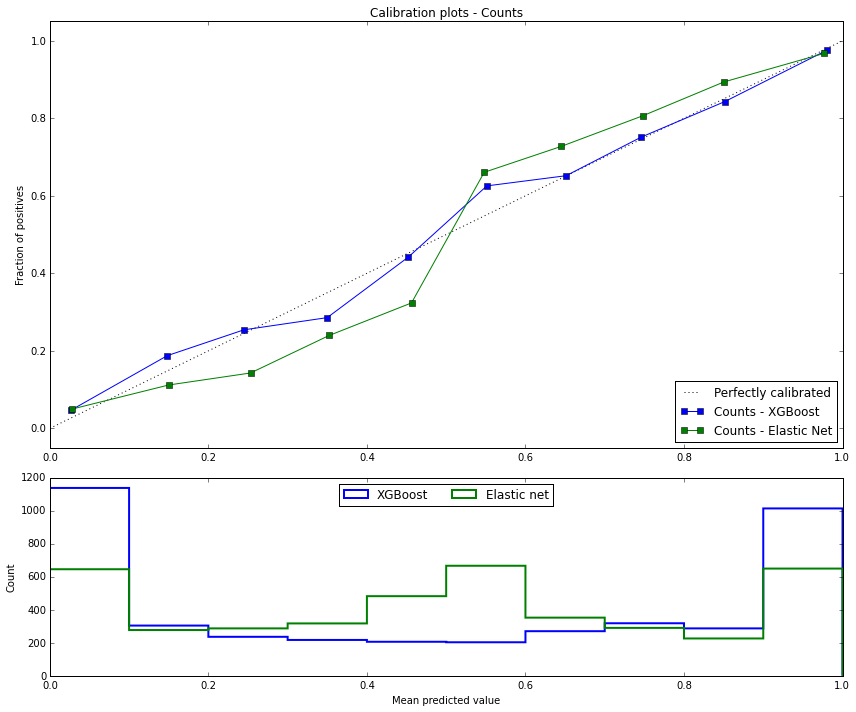

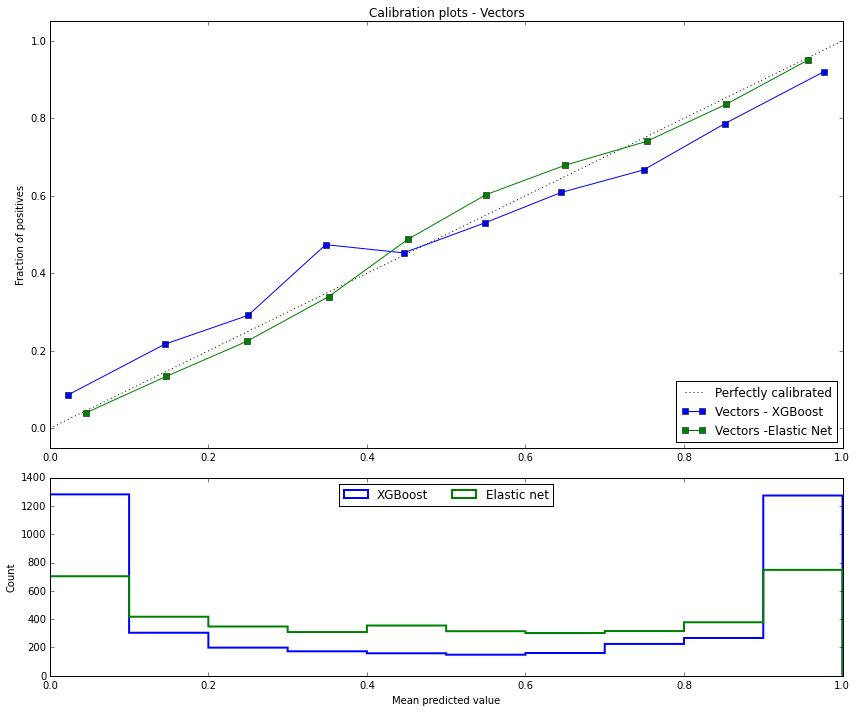

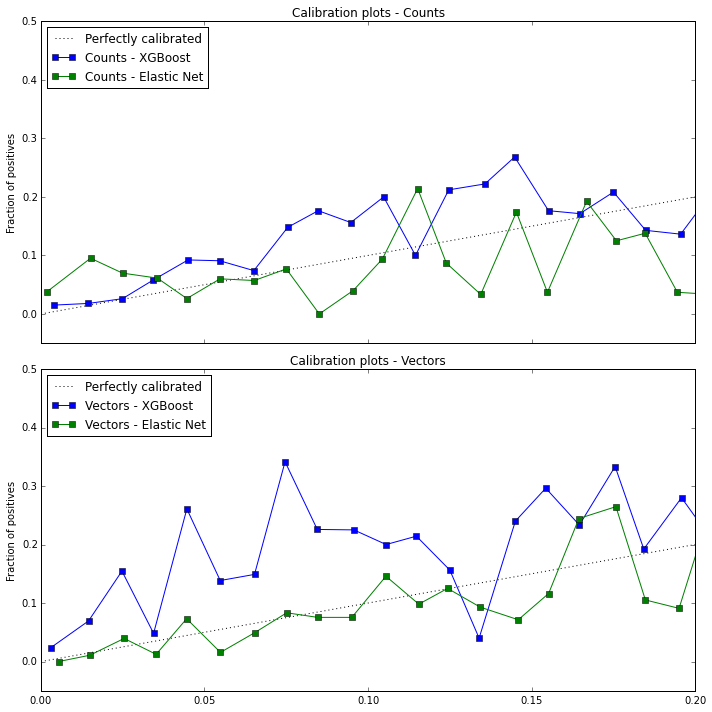

In [8]:
from sklearn.calibration import calibration_curve

MONTHS = 12

# Counts
plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

prob_pos = counts_preds[MONTHS]['pred_y'][:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(counts_preds[MONTHS]['true_y'], prob_pos, n_bins=10)

prob_pos_e = counts_elasticnet_preds[MONTHS]['pred_y'][:, 1]
fraction_of_positives_e, mean_predicted_value_e = calibration_curve(counts_elasticnet_preds[MONTHS]['true_y'], prob_pos_e, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Counts - XGBoost")
ax1.plot(mean_predicted_value_e, fraction_of_positives_e, "s-", label="Counts - Elastic Net")
ax2.hist(prob_pos, range=(0, 1), bins=10, label="XGBoost", histtype="step", lw=2)
ax2.hist(prob_pos_e, range=(0, 1), bins=10, label="Elastic net", histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots - Counts')
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
plt.tight_layout()
plt.show()

# Vectors
plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

prob_pos = vector_preds[MONTHS]['pred_y'][:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(vector_preds[MONTHS]['true_y'], prob_pos, n_bins=10)

prob_pos_e = vector_elasticnet_preds[MONTHS]['pred_y'][:, 1]
fraction_of_positives_e, mean_predicted_value_e = calibration_curve(vector_elasticnet_preds[MONTHS]['true_y'], prob_pos_e, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Vectors - XGBoost")
ax1.plot(mean_predicted_value_e, fraction_of_positives_e, "s-", label="Vectors -Elastic Net")
ax2.hist(prob_pos, range=(0, 1), bins=10, label="XGBoost", histtype="step", lw=2)
ax2.hist(prob_pos_e, range=(0, 1), bins=10, label="Elastic net", histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots - Vectors')
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
plt.tight_layout()
plt.show()

display(HTML('<h3>Zoomed in (0-0.2)</h3>'))

## Zoom in (0. - 0.2)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
axarr[1].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

prob_pos = counts_preds[MONTHS]['pred_y'][:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(counts_preds[MONTHS]['true_y'], prob_pos, n_bins=100)
prob_pos_e = counts_elasticnet_preds[MONTHS]['pred_y'][:, 1]
fraction_of_positives_e, mean_predicted_value_e = calibration_curve(counts_elasticnet_preds[MONTHS]['true_y'], prob_pos_e, n_bins=100)

axarr[0].plot(mean_predicted_value, fraction_of_positives, "s-", label="Counts - XGBoost")
axarr[0].plot(mean_predicted_value_e, fraction_of_positives_e, "s-", label="Counts - Elastic Net")
axarr[0].set_ylabel("Fraction of positives")
axarr[0].set_ylim([-0.05, 0.5])
axarr[0].set_xlim([0, 0.2])
axarr[0].legend(loc="upper left")
axarr[0].set_title('Calibration plots - Counts')

prob_pos = vector_preds[MONTHS]['pred_y'][:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(vector_preds[MONTHS]['true_y'], prob_pos, n_bins=100)
prob_pos_e = vector_elasticnet_preds[MONTHS]['pred_y'][:, 1]
fraction_of_positives_e, mean_predicted_value_e = calibration_curve(vector_elasticnet_preds[MONTHS]['true_y'], prob_pos_e, n_bins=100)

axarr[1].plot(mean_predicted_value, fraction_of_positives, "s-", label="Vectors - XGBoost")
axarr[1].plot(mean_predicted_value_e, fraction_of_positives_e, "s-", label="Vectors - Elastic Net")
axarr[1].set_ylabel("Fraction of positives")
axarr[1].set_ylim([-0.05, 0.5])
axarr[1].set_xlim([0, 0.2])
axarr[1].legend(loc="upper left")
axarr[1].set_title('Calibration plots - Vectors')

plt.tight_layout()
plt.show()

# Precision/recall

Optimized. 12 months before dataset. Vectors used: vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill (PVDBOW, HS, windows size 30, embedding size 100)

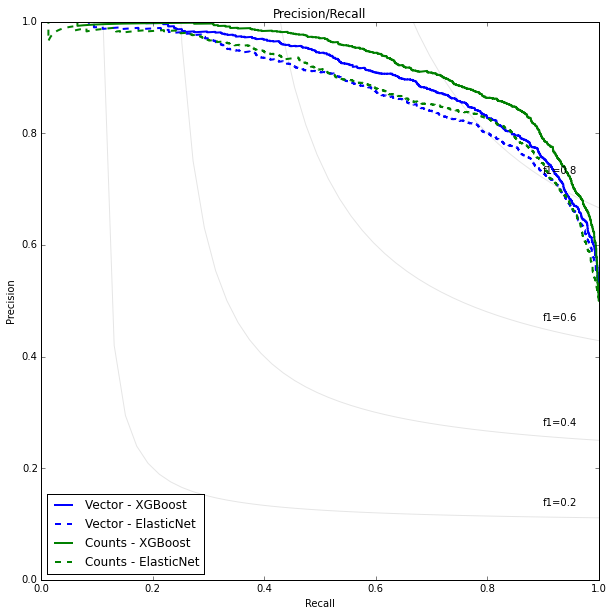

In [9]:
from sklearn.metrics import precision_recall_curve

MONTHS = 12

# Vectors
prob_pos = vector_preds[MONTHS]['pred_y'][:, 1]
precision, recall, _ = precision_recall_curve(vector_preds[MONTHS]['true_y'], prob_pos)
prob_pos_e = vector_elasticnet_preds[MONTHS]['pred_y'][:, 1]
precision_e, recall_e, _ = precision_recall_curve(vector_elasticnet_preds[MONTHS]['true_y'], prob_pos_e)

# Counts
c_prob_pos = counts_preds[MONTHS]['pred_y'][:, 1]
c_precision, c_recall, _ = precision_recall_curve(counts_preds[MONTHS]['true_y'], c_prob_pos)
c_prob_pos_e = counts_elasticnet_preds[MONTHS]['pred_y'][:, 1]
c_precision_e, c_recall_e, _ = precision_recall_curve(counts_preds[MONTHS]['true_y'], c_prob_pos_e)

f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision, 'b', lw=2, label="Vector - XGBoost")
plt.plot(recall_e, precision_e , 'b--', lw=2, label="Vector - ElasticNet")
plt.plot(c_recall, c_precision, 'g', lw=2, label="Counts - XGBoost")
plt.plot(c_recall_e, c_precision_e, 'g--',  lw=2, label="Counts - ElasticNet")
plt.ylabel("Precision")
plt.ylim((0,1))
plt.xlim((0,1))
plt.xlabel("Recall")
plt.legend(loc="lower left")
plt.title('Precision/Recall')
plt.show()

# Learning curves (XGBoost)

Optimized. XGBoost for 12 months before dataset. Vectors used: vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill (PVDBOW, HS, windows size 30, embedding size 100)

/Users/jacek/.pyenv/versions/3.5.0/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


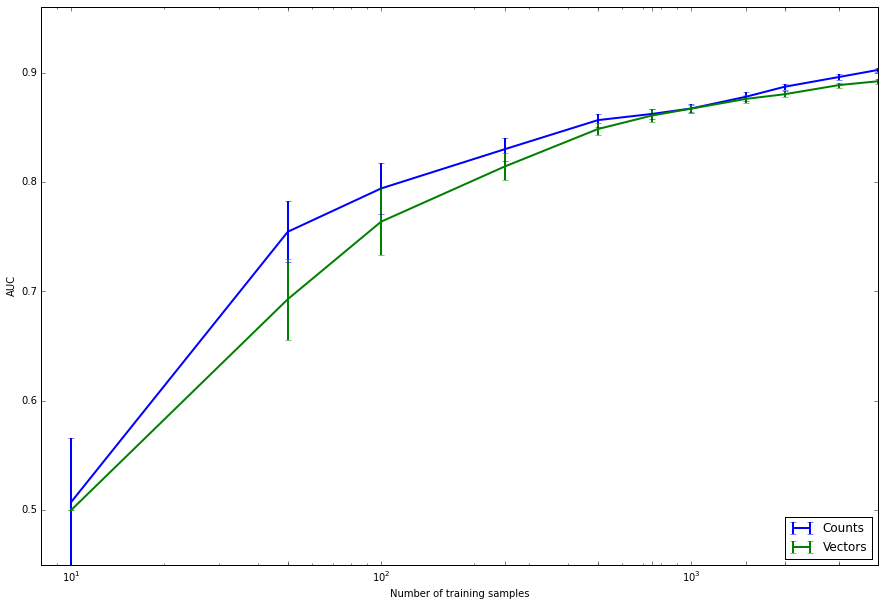

In [10]:
# Counts
lc_counts_df = pd.read_csv('log/diabetes_counts_monthly_optimized_learning_curves.log', header=None)
lc_counts_df.columns = ['samples', 'auc', 'logloss']
lc_counts_sample_groups = lc_counts_df.groupby(by='samples')

samples = []
lc_counts_means = []
lc_counts_stds = []

for g, g_df in lc_counts_sample_groups:
    samples.append(g)
    lc_counts_means.append(g_df['auc'].mean())
    lc_counts_stds.append(g_df['auc'].std())
    
# Vectors

# Vector performace based on patient2vec : PVDBOW, HS, windows size 30, embedding size 100
lc_vectors_df = pd.read_csv('log/diabetes_vectors_monthly_optimized_learning_curves.log', header=None)
lc_vectors_df.columns = ['samples', 'auc', 'logloss']
lc_vectors_sample_groups = lc_vectors_df.groupby(by='samples')

lc_vectors_means = []
lc_vectors_stds = []

for g, g_df in lc_vectors_sample_groups:
    lc_vectors_means.append(g_df['auc'].mean())
    lc_vectors_stds.append(g_df['auc'].std())
    
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

plt.errorbar(samples, lc_counts_means, yerr=lc_counts_stds, label='Counts', linewidth=2.0)
plt.errorbar(samples, lc_vectors_means, yerr=lc_vectors_stds, label='Vectors', linewidth=2.0)
plt.legend(loc='lower right')
plt.xlim((8,2500))
plt.xlabel('Number of training samples')
plt.xscale('log')
plt.xticks(samples)
plt.ylim((0.45,0.96))
plt.ylabel('AUC')
plt.show()